In [1]:
# Cell 1 — Imports, configuration, and helper utilities
# ----------------------------------------------------
# This cell:
#   1) imports all libraries used downstream,
#   2) defines project directories and creates them,
#   3) configures a single HTTP session for repeatable web requests,
#   4) defines a small helper to perform HTTP GET requests safely.

from __future__ import annotations
# Enables postponed evaluation of type annotations.
# Useful for forward references in type hints and to avoid some runtime import issues.

import os
# Standard library: operating-system utilities (paths, env vars). Not strictly required here,
# but often used later for environment handling.

import re
# Standard library: regular expressions. Used for matching filenames/years in scraped URLs.

import io
# Standard library: in-memory streams (BytesIO/StringIO). Useful when reading zip/bytes without writing to disk.

import zipfile
# Standard library: read and extract ZIP archives (e.g., boundaries downloads).

import math
# Standard library: mathematical functions/constants. Sometimes used for computations in later cells.

import time
# Standard library: sleep/timing. Useful for polite crawling (rate limiting) during downloads.

from dataclasses import dataclass
# Provides the @dataclass decorator for lightweight “struct-like” classes (used for discovered file metadata).

from pathlib import Path
# Object-oriented filesystem paths. Preferred over raw strings for robust path manipulation.

from typing import Iterable, Optional, Tuple, List, Dict
# Type-hinting primitives. Helps readability and makes intent explicit (esp. in functions).

import requests
# HTTP client library used for scraping directory listings and downloading NetCDF files.

from bs4 import BeautifulSoup
# HTML parser used to extract links from NOAA PSL directory listing pages.

import pandas as pd
# Tabular data handling. Used to store discovered files and URLs in DataFrames.

import numpy as np
# Numerical computing; used for arrays, vectorization, and basic math.

import xarray as xr
# Core package for labeled N-D arrays and NetCDF handling, used throughout for climate data.

import geopandas as gpd
# Geospatial vector data (GeoJSON/Shapefile) handling; used for country boundaries and geometry operations.

import rasterio
# Geospatial raster utilities; originally used for rasterization of polygons to a grid.

from rasterio import features
# Provides rasterize utilities. Imported for convenience.

import matplotlib.pyplot as plt
# Plotting library used for timeseries and map figures.

# ------------------------
# User configuration
# ------------------------

NCEP_BASE = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface/"
# Base URL for NCEP Reanalysis daily averages on NOAA PSL.
# NOTE: if using 2m temperature, you likely want:
#   "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface_gauss/"
# rather than "/surface/".

DATA_DIR = Path("./data")
# Root directory where all downloaded/derived data will be stored.

NCEP_DIR = DATA_DIR / "ncep_dailyavgs"
# Directory for storing downloaded NCEP NetCDF files.

BOUNDARY_DIR = DATA_DIR / "boundaries_wb"
# Directory for storing World Bank boundaries (GeoJSON, shapefiles, etc.).

OUTPUT_DIR = Path("./outputs")
# Directory for saving final outputs (NetCDF anomaly maps, WSDI maps, plots, etc.).

for d in [DATA_DIR, NCEP_DIR, BOUNDARY_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)
    # Create each directory if it doesn’t already exist.
    # parents=True creates intermediate directories as needed.
    # exist_ok=True prevents errors if the directory already exists.

# ------------------------
# HTTP session configuration
# ------------------------

SESSION = requests.Session()
# A Session reuses TCP connections and keeps headers/cookies consistent across requests.
# This is faster and more reproducible than calling requests.get repeatedly.

SESSION.headers.update({"User-Agent": "Mozilla/5.0 (compatible; climate-notebook/1.0)"})
# Set a User-Agent header so the remote server can identify traffic as coming from a script.
# Some servers behave better (or avoid blocking) when a realistic User-Agent is provided.

def http_get(url: str, *, timeout: int = 60) -> requests.Response:
    """
    Perform an HTTP GET request with error handling.

    Parameters
    ----------
    url : str
        Target URL to request.
    timeout : int, optional (default=60)
        Seconds before the request times out (prevents hanging indefinitely).

    Returns
    -------
    requests.Response
        The response object (already validated for HTTP errors).

    Raises
    ------
    requests.HTTPError
        If the server returns a non-2xx response code (e.g., 404/500).
    """
    r = SESSION.get(url, timeout=timeout)
    # Issue a GET request using the shared session.

    r.raise_for_status()
    # Raises requests.HTTPError if status code indicates a failure.

    return r
    # Return the Response so callers can access .text, .content, headers, etc.

In [2]:
# Cell 2 — Robust discovery of NCEP Reanalysis daily NetCDF files (NOAA PSL)
# ------------------------------------------------------------------------
# This cell scrapes the NOAA PSL directory listings to discover NetCDF files
# programmatically (rather than hardcoding filenames/paths).
#
# It provides:
#   - list_directory_links(): parse a directory listing page and return hrefs
#   - url_exists(): verify candidate subdirectories exist (avoids dead links)
#   - discover_ncep_dailyavgs_files(): BFS crawl + filtering to return a DataFrame

from urllib.parse import urljoin
# urljoin safely joins a base URL with a relative path (handles missing/extra slashes correctly).

from requests.exceptions import HTTPError
# HTTPError is raised by requests when .raise_for_status() encounters non-2xx responses.

def list_directory_links(url: str) -> List[str]:
    """
    Parse an Apache-style directory listing and return all hyperlink targets.

    Parameters
    ----------
    url : str
        URL of a directory listing (e.g., https://.../surface_gauss/)

    Returns
    -------
    List[str]
        All 'href' strings found on the page. Returns an empty list for 404
        (directory does not exist), so the crawler can skip gracefully.
    """
    try:
        # Fetch the HTML content of the directory listing page
        html = http_get(url).text
    except HTTPError as e:
        # Some “directories” appear as links in listings but do not actually exist on the server.
        # For a 404 we treat it as “no links here” rather than failing the whole run.
        if e.response is not None and e.response.status_code == 404:
            return []
        # For other errors (500, permission issues, etc.), re-raise so they are not silently ignored.
        raise

    # Parse HTML and extract all anchor tags (<a href="...">)
    soup = BeautifulSoup(html, "html.parser")

    # Return a cleaned list of hrefs (strip whitespace; ignore anchors without href)
    return [a.get("href").strip() for a in soup.find_all("a") if a.get("href")]


def url_exists(url: str) -> bool:
    """
    Check whether a URL exists and is reachable.

    This is used to prevent the crawler from descending into navigation links
    (e.g. "about/") that appear in listings but are not real directories.

    Returns
    -------
    bool
        True if the server returns HTTP 200, else False.
    """
    try:
        # HEAD is cheap (no body), and is sufficient to test existence on most servers.
        r = SESSION.head(url, timeout=20, allow_redirects=True)

        # Some servers do not allow HEAD and return 405 Method Not Allowed,
        # so we fall back to GET in that case.
        if r.status_code == 405:
            r = SESSION.get(url, timeout=20, allow_redirects=True)

        # Return True only for 200 OK (treat redirects as OK via allow_redirects=True).
        return r.status_code == 200
    except Exception:
        # Any network issues/timeouts/etc. are treated as “does not exist / not reachable”.
        return False


def discover_ncep_dailyavgs_files(
    variable: str,
    year_start: int,
    year_end: int,
    *,
    base_url: str = NCEP_BASE,
    max_depth: int = 2,
    include_regex: Optional[str] = None,
) -> pd.DataFrame:
    """
    Discover NetCDF files for a variable across the NCEP daily averages dataset tree.

    The function crawls NOAA PSL directory listings starting at base_url, and filters:
      - filenames must start with '<variable>.' (e.g., 'air.')
      - filenames must end with '.YYYY.nc' for a target year range
      - optional include_regex can further constrain product variants (e.g. '2m.gauss' or 'sig995')

    Parameters
    ----------
    variable : str
        Variable prefix used in filenames (e.g., "air", "hgt", "uwnd").
    year_start, year_end : int
        Inclusive year range to return.
    base_url : str
        Root directory to crawl. Example:
          - surface/ for sigma-level “near-sfc” products (e.g. air.sig995.YYYY.nc)
          - surface_gauss/ for 2m products (e.g. air.2m.gauss.YYYY.nc)
    max_depth : int
        Maximum subdirectory depth for BFS crawl.
        (Keeps crawl bounded and avoids traversing unrelated content.)
    include_regex : Optional[str]
        Additional regex filter applied to the filename (e.g., r"2m\\.gauss" or r"sig995").

    Returns
    -------
    pandas.DataFrame
        Columns:
          - subdir: relative subdirectory under base_url
          - year: parsed year
          - filename: NetCDF filename
          - url: fully qualified download URL
    """
    # Validate range early
    if year_start > year_end:
        raise ValueError("year_start must be <= year_end")

    # Regex to capture trailing ".YYYY.nc" year token
    year_re = re.compile(r"\.(\d{4})\.nc$")

    # NOAA PSL filenames typically begin with "<variable>.", e.g., "air.2m.gauss.1981.nc"
    var_prefix = variable.strip() + "."

    # Optional user-provided product filter (compiled once for efficiency)
    extra_re = re.compile(include_regex) if include_regex else None

    # Directory listings often include navigation-like links which are not real directories
    # in the dataset tree. We exclude common ones explicitly.
    BAD_SUBDIRS = {"about/", "doc/", "docs/", "help/", "tools/", "cgi-bin/"}

    # BFS queue elements are tuples: (relative_subpath, absolute_url, depth)
    queue = [("", base_url, 0)]

    # Track visited URLs to avoid infinite loops / redundant parsing
    visited = set()

    # Collect discovered file records here (list of dicts -> DataFrame at end)
    found = []

    while queue:
        # Pop the next directory to explore (FIFO -> breadth-first)
        subpath, url, depth = queue.pop(0)

        # Skip already-visited directory URLs
        if url in visited:
            continue
        visited.add(url)

        # Get all links (hrefs) from this directory listing
        hrefs = list_directory_links(url)

        for href in hrefs:

            # Skip parent/current directory anchors typically present in Apache listings
            if href in ("../", "./"):
                continue

            # ---- Handle subdirectories ----
            # Apache directory listings represent subdirectories as hrefs ending with "/"
            if href.endswith("/") and depth < max_depth:

                # Skip known “navigation” subdirs (not actual data folders)
                if href.lower() in BAD_SUBDIRS:
                    continue

                # Skip absolute URLs/paths; we only follow relative folder names
                if href.startswith(("http://", "https://", "/")):
                    continue

                # Construct next directory path and full URL
                next_subpath = subpath + href
                next_url = urljoin(base_url, next_subpath)

                # Only follow subdirectories that genuinely exist (avoids dead ends like surface/about/)
                if not url_exists(next_url):
                    continue

                # Add subdirectory to BFS queue
                queue.append((next_subpath, next_url, depth + 1))
                continue

            # ---- Handle NetCDF files ----
            # Only consider .nc files; ignore other file types (README, .txt, etc.)
            if not href.endswith(".nc"):
                continue

            # Ignore absolute URLs/paths; we only handle relative filenames in the listing
            if href.startswith(("http://", "https://", "/")):
                continue

            filename = href

            # Require filename to match the variable prefix
            if not filename.startswith(var_prefix):
                continue

            # Parse year from filename suffix
            m = year_re.search(filename)
            if not m:
                continue
            year = int(m.group(1))

            # Filter by requested year range
            if not (year_start <= year <= year_end):
                continue

            # Apply optional product filter (e.g., restrict to "sig995" or "2m.gauss")
            if extra_re and not extra_re.search(filename):
                continue

            # Record the discovered file
            found.append({
                "subdir": subpath,                 # relative directory under base_url
                "year": year,                      # parsed year
                "filename": filename,              # NetCDF filename
                "url": urljoin(url, filename),     # full download URL
            })

    # Convert list of dicts to DataFrame and sort for reproducible order
    df = pd.DataFrame(found).sort_values(["year", "subdir", "filename"]).reset_index(drop=True)

    # Fail loudly if no files found (usually means wrong base_url, regex, or depth)
    if df.empty:
        raise RuntimeError(
            f"No files found for variable='{variable}' in {year_start}-{year_end}. "
            f"Try include_regex='sig995' or set base_url to surface_gauss and include_regex='2m\\.gauss'."
        )

    return df


# ---- Run discovery ----
# Example: sigma-level near-surface temperature
df_air = discover_ncep_dailyavgs_files(
    "air",                 # variable prefix in filenames
    1981,                  # start year (inclusive)
    2025,                  # end year (inclusive)
    include_regex=r"sig995",  # product selector; for 2m temperature use r"2m\.gauss"
    max_depth=2,           # crawl depth; may need >=3 depending on base_url subtree
)

# Show quick inspection outputs: head/tail and subdirectory distribution
df_air.head(), df_air.tail(), df_air["subdir"].value_counts()

(  subdir  year            filename  \
 0         1981  air.sig995.1981.nc   
 1         1982  air.sig995.1982.nc   
 2         1983  air.sig995.1983.nc   
 3         1984  air.sig995.1984.nc   
 4         1985  air.sig995.1985.nc   
 
                                                  url  
 0  https://downloads.psl.noaa.gov/Datasets/ncep.r...  
 1  https://downloads.psl.noaa.gov/Datasets/ncep.r...  
 2  https://downloads.psl.noaa.gov/Datasets/ncep.r...  
 3  https://downloads.psl.noaa.gov/Datasets/ncep.r...  
 4  https://downloads.psl.noaa.gov/Datasets/ncep.r...  ,
    subdir  year            filename  \
 40         2021  air.sig995.2021.nc   
 41         2022  air.sig995.2022.nc   
 42         2023  air.sig995.2023.nc   
 43         2024  air.sig995.2024.nc   
 44         2025  air.sig995.2025.nc   
 
                                                   url  
 40  https://downloads.psl.noaa.gov/Datasets/ncep.r...  
 41  https://downloads.psl.noaa.gov/Datasets/ncep.r...  
 42  https://d

In [4]:
# Cell 3 — Download manager (uses discovery DataFrame)
# ---------------------------------------------------
# This cell implements a small, robust downloader that:
#   1) iterates over the discovered file table (DataFrame),
#   2) downloads each file,
#   3) saves to disk safely using streaming,
#   4) optionally skips existing files,
#   5) returns a list of local paths for downstream processing.
#
# Design goals:
#   - reproducible
#   - restartable (does not re-download existing files)
#   - memory-safe (streams large NetCDFs)
#   - polite to servers (optional sleep between requests)

def download_files_from_df(
    df: pd.DataFrame,
    out_dir: Path,
    *,
    url_col: str = "url",
    filename_col: str = "filename",
    overwrite: bool = False,
    sleep_s: float = 0.0,
) -> List[Path]:
    """
    Download files listed in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Table produced by the discovery step. Must contain columns
        with file URLs and filenames.
    out_dir : Path
        Directory where downloaded files will be stored.
    url_col : str
        Name of the column containing download URLs.
    filename_col : str
        Name of the column containing filenames.
    overwrite : bool
        If False (default), existing files are skipped.
        If True, files are re-downloaded even if present.
    sleep_s : float
        Optional delay between downloads (seconds).
        Useful for rate-limiting to avoid overloading the remote server.

    Returns
    -------
    List[Path]
        List of local file paths corresponding to downloaded (or existing) files.
    """

    # Ensure output directory exists
    out_dir.mkdir(parents=True, exist_ok=True)

    # Will store full local paths of all files (downloaded or skipped)
    paths: List[Path] = []

    # Iterate over each discovered file record
    # iterrows() gives index + row; we ignore index using "_"
    for _, row in df.iterrows():

        # Extract URL and filename from the DataFrame
        url = str(row[url_col])
        fname = str(row[filename_col])

        # Construct full local output path
        out_path = out_dir / fname

        # ---------------------------------------------------------
        # Skip download if file already exists (restartable behavior)
        # ---------------------------------------------------------
        if out_path.exists() and not overwrite:
            paths.append(out_path)
            continue

        # ---------------------------------------------------------
        # Download file using streaming
        # ---------------------------------------------------------
        # http_get returns a requests.Response object
        # Streaming avoids loading the entire file into memory (important
        # for large NetCDFs, often hundreds of MB)
        with http_get(url, timeout=120) as r:

            # Open local file in binary write mode
            with open(out_path, "wb") as f:

                # iter_content reads data in chunks
                # chunk_size=1 MB balances I/O efficiency and memory use
                for chunk in r.iter_content(chunk_size=1024 * 1024):

                    # Some chunks may be empty keep-alives; skip those
                    if chunk:
                        f.write(chunk)

        # Record the successfully downloaded file
        paths.append(out_path)

        # Optional sleep between downloads (polite crawling)
        if sleep_s > 0:
            time.sleep(sleep_s)

    # Return list of file paths for downstream use (e.g. xarray.open_mfdataset)
    return paths


# ---------------------------------------------------
# Execute download for discovered files
# ---------------------------------------------------
# NOTE:
# If using 2m temperature, you may prefer:
#   out_dir = DATA_DIR / "ncep_dailyavgs_air2m"
# to avoid mixing products.

# Download daily-mean "air" files (currently sigma=0.995)
air_files = download_files_from_df(
    df_air,
    NCEP_DIR,
    overwrite=False,   # skip already downloaded files
    sleep_s=0.0        # no delay between downloads
)

# Quick sanity check: number of files and first/last path
len(air_files), air_files[0], air_files[-1]

(45,
 PosixPath('data/ncep_dailyavgs/air.sig995.1981.nc'),
 PosixPath('data/ncep_dailyavgs/air.sig995.2025.nc'))

In [5]:
# Cell 4 — Open dataset with xarray; basic cleanup
# ------------------------------------------------
# Purpose:
#   1) Open many yearly NetCDF files as a single logical dataset
#   2) Enable lazy loading with Dask (memory efficient)
#   3) Standardize longitude coordinates for consistent geospatial operations
#
# Why this matters scientifically:
#   - ensures reproducible merging of time series
#   - avoids loading entire dataset into RAM
#   - prevents lon mismatch issues when masking with shapefiles

def open_ncep_air_dataset(
    nc_paths: List[Path],
    *,
    chunks: Optional[Dict[str, int]] = None
) -> xr.Dataset:
    """
    Open multiple annual NetCDF files as one xarray Dataset.

    Parameters
    ----------
    nc_paths : List[Path]
        Paths to individual yearly NetCDF files (e.g. air.2m.gauss.1981.nc, ...).
    chunks : Optional[Dict[str, int]]
        Dask chunk sizes. Controls how data are split into blocks for lazy loading.
        Example: {"time": 365, "lat": 73, "lon": 144}

    Returns
    -------
    xr.Dataset
        Combined dataset with continuous time dimension.
    """

    # Convert Path objects to strings (xarray expects str paths)
    paths = [str(p) for p in nc_paths]

    # ---------------------------------------------------------
    # Open multiple files simultaneously
    # ---------------------------------------------------------
    # open_mfdataset:
    #   - reads metadata immediately
    #   - defers actual data loading (lazy/Dask)
    #   - concatenates along matching coordinates automatically
    #
    # combine="by_coords":
    #   Aligns and concatenates files using shared coordinate labels (time),
    #   rather than assuming simple stacking order.
    #   This is safer and more robust if files are not perfectly ordered.
    #
    # parallel=True:
    #   Allows Dask to read files concurrently (faster on multi-core systems/HPC).
    #
    # chunks:
    #   Defines block sizes for lazy loading. Smaller chunks → lower memory use,
    #   larger chunks → faster computation. Tunable depending on hardware.
    #
    # engine="netcdf4":
    #   Uses the netCDF4 backend for compatibility with classic NetCDF files.

    ds = xr.open_mfdataset(
        paths,
        combine="by_coords",
        parallel=True,
        chunks=chunks or {"time": 365},  # default: roughly yearly chunks
        engine="netcdf4",
    )

    # ---------------------------------------------------------
    # Standardize longitude convention
    # ---------------------------------------------------------
    # Some datasets use 0–360 degrees
    # Others use −180–180 degrees
    #
    # Shapefiles/GeoJSON typically use −180–180.
    # If we don’t standardize, spatial masking will fail.
    #
    # Convert only if necessary.

    if "lon" in ds.coords:

        lon = ds["lon"]

        # If max longitude > 180 → we are in 0–360 convention
        if lon.max() > 180:

            # Convert to −180–180 using modular arithmetic
            ds = ds.assign_coords(
                lon=(((lon + 180) % 360) - 180)
            ).sortby("lon")
            # sortby is critical so coordinates remain monotonic after wrapping

    return ds


# ---------------------------------------------------------
# Open the discovered files
# ---------------------------------------------------------
# Example chunking strategy:
#   time = 365  → process ~1 year at a time
#   lat/lon moderate blocks for parallel computation
#
# These values are not scientifically meaningful —
# they are purely performance tuning parameters.

ds = open_ncep_air_dataset(
    air_files,
    chunks={"time": 365, "lat": 73, "lon": 144}
)

# Print dataset summary (dimensions, variables, coordinates)
ds

<xarray.Dataset> Size: 691MB
Dimensions:    (time: 16436, lat: 73, lon: 144, nbnds: 2)
Coordinates:
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 131kB 1981-01-01 1981-01-02 ... 2025-12-31
  * lon        (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
Dimensions without coordinates: nbnds
Data variables:
    air        (time, lat, lon) float32 691MB dask.array<chunksize=(365, 73, 144), meta=np.ndarray>
    time_bnds  (time, nbnds) float64 263kB dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC reanalysis (1981)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    history:        created 95/02/06 by Hoop (netCDF2.3)\nConverted to chunke...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [6]:
# Cell 5 — Load local World Bank boundaries (GeoJSON/JSON) and inspect metadata
# -----------------------------------------------------------------------------
# Purpose:
#   1) Load official country boundaries (vector polygons) from a local file
#   2) Ensure a consistent coordinate reference system (WGS84 lon/lat)
#   3) Inspect schema to identify fields for selecting China
#
# Scientific rationale:
#   - Spatial masking requires the climate grid and polygon geometries
#     to be expressed in the SAME CRS.
#   - Most NetCDF reanalysis data use geographic coordinates (lon/lat, EPSG:4326).
#   - Therefore we standardize the boundaries to EPSG:4326 explicitly.

from pathlib import Path
# Path provides robust, cross-platform filesystem handling.

import geopandas as gpd
# GeoPandas handles vector geospatial data (GeoJSON, Shapefile, etc.)
# Each row contains attributes + a geometry (polygon/multipolygon).


# ---------------------------------------------------------
# Specify location of boundary file
# ---------------------------------------------------------
# This file should be downloaded locally beforehand.
# Expected formats: .geojson, .json, .shp, etc.
#
# Using a local file:
#   - avoids dependence on remote APIs
#   - improves reproducibility
#   - avoids network failures during execution

WB_BOUNDARY_FILE = Path("world_bank_official_boundaries.geojson")  # <-- change if needed


# ---------------------------------------------------------
# Basic existence check
# ---------------------------------------------------------
# Fail early if the file is missing rather than producing confusing errors later.

if not WB_BOUNDARY_FILE.exists():
    raise FileNotFoundError(
        f"Cannot find WB boundary file at: {WB_BOUNDARY_FILE.resolve()}"
    )


# ---------------------------------------------------------
# Read boundary dataset
# ---------------------------------------------------------
# read_file automatically detects format and loads:
#   - geometry column (polygons)
#   - attribute table (country names, ISO codes, etc.)

gdf = gpd.read_file(WB_BOUNDARY_FILE)


# ---------------------------------------------------------
# Ensure consistent Coordinate Reference System (CRS)
# ---------------------------------------------------------
# Climate grids (NetCDF) use geographic coordinates:
#   longitude/latitude in degrees (EPSG:4326, WGS84).
#
# If CRS mismatches:
#   → mask alignment fails
#   → geometry may appear shifted/rotated
#   → results become incorrect silently
#
# Therefore we explicitly enforce EPSG:4326.

if gdf.crs is None:
    # If CRS metadata is missing, assume WGS84 (typical for WB data)
    gdf = gdf.set_crs("EPSG:4326")
else:
    # Reproject to WGS84 if necessary
    gdf = gdf.to_crs("EPSG:4326")


# ---------------------------------------------------------
# Quick inspection (diagnostics)
# ---------------------------------------------------------
# These prints help:
#   - confirm the file loaded correctly
#   - inspect schema to find China identifier column (ISO3, NAME, etc.)
#   - verify CRS

print("Rows:", len(gdf))                # number of polygons/features
print("CRS:", gdf.crs)                 # coordinate system
print("Columns:", list(gdf.columns))    # available attributes

gdf.head()                             # preview first rows

Rows: 264
CRS: EPSG:4326
Columns: ['ISO_A3', 'ISO_A2', 'WB_A3', 'HASC_0', 'GAUL_0', 'WB_REGION', 'WB_STATUS', 'SOVEREIGN', 'NAM_0', 'geometry']


ISO_A3 ISO_A2 WB_A3 HASC_0  GAUL_0 WB_REGION         WB_STATUS SOVEREIGN  \
0    CHN     CN   CHN     CN  147295       EAP      Member State       CHN   
1    JPN     JP   JPN     JP     126     Other      Member State       JPN   
2    KOR     KR   KOR     KR     202       EAP      Member State       KOR   
3    PRK     KP   PRK     KP      67     Other  Non Member State       PRK   
4    RUS     RU   RUS     RU     204       ECA      Member State       RUS   

                NAM_0                                           geometry  
0               China  MULTIPOLYGON (((117.58675 38.59517, 117.58909 ...  
1               Japan  MULTIPOLYGON (((137.48411 34.67386, 137.46683 ...  
2   Republic of Korea  MULTIPOLYGON (((126.05363 36.19852, 126.05372 ...  
3   D. P. R. of Korea  MULTIPOLYGON (((126.95508 38.16282, 126.95184 ...  
4  Russian Federation  MULTIPOLYGON (((130.61904 48.88019, 130.60659 ...

In [7]:
# Cell 6 — Extract China geometry from the WB boundaries GeoDataFrame (robust)
# ---------------------------------------------------------------------------
# Purpose:
#   Identify and extract the polygon geometry representing mainland China
#   from the World Bank boundary dataset.
#
# Why this step matters scientifically:
#   - Defines the spatial domain of all subsequent statistics
#   - Errors here silently bias results (wrong country, missing pieces, etc.)
#   - WB schemas vary, so we cannot rely on a single column name
#
# Strategy (robust multi-step matching):
#   1) Prefer ISO code match (CHN)  → most reliable
#   2) Fallback to name match ("China")
#   3) Last-resort text search across all columns
#   4) Dissolve multiple polygons into one geometry (unary_union)

import re
# Regular expressions used for flexible text matching


def extract_china_geometry(gdf: gpd.GeoDataFrame) -> object:
    """
    Extract a shapely geometry representing China.

    Handles multiple common schemas automatically and merges multipart
    geometries into one polygon/multipolygon.

    Parameters
    ----------
    gdf : GeoDataFrame
        World Bank boundaries table containing one row per country/region.

    Returns
    -------
    shapely geometry (Polygon or MultiPolygon)
        Dissolved China geometry suitable for masking.

    Notes
    -----
    Priority order:
        1) ISO3 code match (most reliable)
        2) Country name match
        3) Fallback free-text search

    Hong Kong and Macau are excluded if listed separately to ensure
    consistent "mainland China" definition.
    """

    # ---------------------------------------------------------
    # Possible ISO code column names (varies across datasets)
    # ---------------------------------------------------------
    # Different WB releases use different naming conventions.
    # We check multiple possibilities to be robust.

    iso_cols = ["ISO3", "iso3", "ADM0_ISO", "WB_A3", "ISO_A3", "iso_a3"]

    # ---------------------------------------------------------
    # Possible country name column names
    # ---------------------------------------------------------
    name_cols = ["NAME_EN", "NAME", "COUNTRY", "ADMIN", "admin", "name", "name_en"]


    # =========================================================
    # 1) ISO3 MATCH (preferred, most precise)
    # =========================================================
    # ISO code "CHN" uniquely identifies China and avoids ambiguity.

    for c in iso_cols:
        if c in gdf.columns:

            # Standardize to uppercase strings
            s = gdf[c].astype(str).str.upper()

            # Select rows matching CHN
            sub = gdf[s.eq("CHN")]

            if len(sub) > 0:
                # unary_union merges multiple geometries into one
                # (important if boundaries are split into parts)
                return sub.geometry.unary_union


    # =========================================================
    # 2) NAME MATCH (fallback)
    # =========================================================
    # Used if ISO code missing. Searches for "China" in name columns.

    for c in name_cols:
        if c in gdf.columns:

            s = gdf[c].astype(str)

            # Find rows containing the word "China"
            sub = gdf[s.str.contains(r"\bChina\b", case=False, na=False)]

            if len(sub) > 0:

                # Exclude Hong Kong / Macau if provided separately
                # These sometimes appear as distinct administrative regions
                excl = s.str.contains("Hong Kong|Macao|Macau", case=False, na=False)

                sub2 = sub.loc[~excl.loc[sub.index]]

                # Use mainland-only if available, otherwise full selection
                return (sub2 if len(sub2) > 0 else sub).geometry.unary_union


    # =========================================================
    # 3) LAST-RESORT FALLBACK (text search across all columns)
    # =========================================================
    # Very defensive: search any textual column for CHN/China
    # Ensures something is returned even for unusual schemas.

    text = gdf.astype(str).apply(lambda col: col.str.lower())

    mask = text.apply(
        lambda col: col.str.contains(r"\bchn\b|\bchina\b", na=False)
    ).any(axis=1)

    sub = gdf[mask]

    if len(sub) > 0:
        return sub.geometry.unary_union


    # =========================================================
    # If all methods fail, stop clearly
    # =========================================================
    raise RuntimeError(
        "Could not identify China in boundaries file. "
        "Run: gdf.columns and gdf.head() and adjust selector."
    )


# ---------------------------------------------------------
# Execute extraction
# ---------------------------------------------------------
# china_geom is a shapely Polygon or MultiPolygon
# Used later for grid masking

china_geom = extract_china_geometry(gdf)

china_geom
# Cell 6 — Extract China geometry from the WB boundaries GeoDataFrame (robust)
# ---------------------------------------------------------------------------
# Purpose:
#   Identify and extract the polygon geometry representing mainland China
#   from the World Bank boundary dataset.
#
# Why this step matters scientifically:
#   - Defines the spatial domain of all subsequent statistics
#   - Errors here silently bias results (wrong country, missing pieces, etc.)
#   - WB schemas vary, so we cannot rely on a single column name
#
# Strategy (robust multi-step matching):
#   1) Prefer ISO code match (CHN)  → most reliable
#   2) Fallback to name match ("China")
#   3) Last-resort text search across all columns
#   4) Dissolve multiple polygons into one geometry (unary_union)

import re
# Regular expressions used for flexible text matching


def extract_china_geometry(gdf: gpd.GeoDataFrame) -> object:
    """
    Extract a shapely geometry representing China.

    Handles multiple common schemas automatically and merges multipart
    geometries into one polygon/multipolygon.

    Parameters
    ----------
    gdf : GeoDataFrame
        World Bank boundaries table containing one row per country/region.

    Returns
    -------
    shapely geometry (Polygon or MultiPolygon)
        Dissolved China geometry suitable for masking.

    Notes
    -----
    Priority order:
        1) ISO3 code match (most reliable)
        2) Country name match
        3) Fallback free-text search

    Hong Kong and Macau are excluded if listed separately to ensure
    consistent "mainland China" definition.
    """

    # ---------------------------------------------------------
    # Possible ISO code column names (varies across datasets)
    # ---------------------------------------------------------
    # Different WB releases use different naming conventions.
    # We check multiple possibilities to be robust.

    iso_cols = ["ISO3", "iso3", "ADM0_ISO", "WB_A3", "ISO_A3", "iso_a3"]

    # ---------------------------------------------------------
    # Possible country name column names
    # ---------------------------------------------------------
    name_cols = ["NAME_EN", "NAME", "COUNTRY", "ADMIN", "admin", "name", "name_en"]


    # =========================================================
    # 1) ISO3 MATCH (preferred, most precise)
    # =========================================================
    # ISO code "CHN" uniquely identifies China and avoids ambiguity.

    for c in iso_cols:
        if c in gdf.columns:

            # Standardize to uppercase strings
            s = gdf[c].astype(str).str.upper()

            # Select rows matching CHN
            sub = gdf[s.eq("CHN")]

            if len(sub) > 0:
                # unary_union merges multiple geometries into one
                # (important if boundaries are split into parts)
                return sub.geometry.unary_union


    # =========================================================
    # 2) NAME MATCH (fallback)
    # =========================================================
    # Used if ISO code missing. Searches for "China" in name columns.

    for c in name_cols:
        if c in gdf.columns:

            s = gdf[c].astype(str)

            # Find rows containing the word "China"
            sub = gdf[s.str.contains(r"\bChina\b", case=False, na=False)]

            if len(sub) > 0:

                # Exclude Hong Kong / Macau if provided separately
                # These sometimes appear as distinct administrative regions
                excl = s.str.contains("Hong Kong|Macao|Macau", case=False, na=False)

                sub2 = sub.loc[~excl.loc[sub.index]]

                # Use mainland-only if available, otherwise full selection
                return (sub2 if len(sub2) > 0 else sub).geometry.unary_union


    # =========================================================
    # 3) LAST-RESORT FALLBACK (text search across all columns)
    # =========================================================
    # Very defensive: search any textual column for CHN/China
    # Ensures something is returned even for unusual schemas.

    text = gdf.astype(str).apply(lambda col: col.str.lower())

    mask = text.apply(
        lambda col: col.str.contains(r"\bchn\b|\bchina\b", na=False)
    ).any(axis=1)

    sub = gdf[mask]

    if len(sub) > 0:
        return sub.geometry.unary_union


    # =========================================================
    # If all methods fail, stop clearly
    # =========================================================
    raise RuntimeError(
        "Could not identify China in boundaries file. "
        "Run: gdf.columns and gdf.head() and adjust selector."
    )


# ---------------------------------------------------------
# Execute extraction
# ---------------------------------------------------------
# china_geom is a shapely Polygon or MultiPolygon
# Used later for grid masking

china_geom = extract_china_geometry(gdf)

china_geom

/tmp/ipykernel_11779/2072352187.py:81: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return sub.geometry.unary_union
/tmp/ipykernel_11779/2072352187.py:225: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return sub.geometry.unary_union


In [41]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Ensure sorted
ds2 = ds.sortby("lat").sortby("lon")
tas_c = ds2["air"] - 273.15
tas_china = tas_c.where(china_mask)

lat = ds2["lat"].values
lon = ds2["lon"].values

# --- latitude edges from midpoints (works for non-uniform spacing) ---
lat_rad = np.deg2rad(lat)

edges = np.empty(lat_rad.size + 1, dtype=float)
edges[1:-1] = 0.5 * (lat_rad[1:] + lat_rad[:-1])
# extrapolate end edges
edges[0]  = lat_rad[0]  - 0.5 * (lat_rad[1] - lat_rad[0])
edges[-1] = lat_rad[-1] + 0.5 * (lat_rad[-1] - lat_rad[-2])

# latitude band weights proportional to area of band: sin(edge_n) - sin(edge_s)
w_lat = np.abs(np.sin(edges[1:]) - np.sin(edges[:-1]))
w_lat = xr.DataArray(w_lat, coords={"lat": ds2["lat"]}, dims=("lat",), name="lat_band_weight")

def area_weighted_mean_gauss(da: xr.DataArray) -> xr.DataArray:
    # lon spacing is uniform, so it cancels out in normalization; lat-band weights are the key
    return da.weighted(w_lat).mean(dim=("lat", "lon"), skipna=True)

tas_ann_mean = area_weighted_mean_gauss(tas_china.resample(time="YS").mean())
tas_jja_mean = area_weighted_mean_gauss(
    tas_china.sel(time=tas_china.time.dt.season=="JJA").resample(time="YS").mean()
)

print("China annual mean (°C):", float(tas_ann_mean.mean()))
print("China JJA mean (°C):", float(tas_jja_mean.mean()))


China annual mean (°C): 5.324534743837304
China JJA mean (°C): 17.567111835712158


In [40]:
tas_c = ds2["air"] - 273.15
tas_china = tas_c.where(china_mask)

w_lat = xr.DataArray(np.cos(np.deg2rad(ds2["lat"])), coords={"lat": ds2["lat"]}, dims=("lat",))

def area_weighted_mean(da):
    return da.weighted(w_lat).mean(dim=("lat","lon"), skipna=True)

tas_ann_mean = area_weighted_mean(tas_china.resample(time="YS").mean())
tas_jja_mean = area_weighted_mean(
    tas_china.sel(time=tas_china.time.dt.season=="JJA").resample(time="YS").mean()
)

print("China annual mean (°C):", float(tas_ann_mean.mean()))
print("China JJA mean (°C):", float(tas_jja_mean.mean()))

China annual mean (°C): 5.324501037597656
China JJA mean (°C): 17.567092895507812


In [18]:
print("Unweighted JJA mean:",
      float(tas_china.sel(time=tas_china.time.dt.season=="JJA").mean().values))

print("Weighted JJA mean:",
      float(tas_jja_mean.mean().values))

Unweighted JJA mean: 17.830366134643555
Weighted JJA mean: 17.7487735748291


In [42]:
print("Whole China annual mean (°C):", float(tas_ann_mean.mean()))
print("Whole China JJA mean (°C):", float(tas_jja_mean.mean()))

Whole China annual mean (°C): 5.324534743837304
Whole China JJA mean (°C): 17.567111835712158


In [43]:
def awm(da):
    return da.weighted(w_lat).mean(dim=("lat","lon"), skipna=True)

# Define a few physically meaningful boxes
east = tas_c.sel(lon=slice(105, 122), lat=slice(20, 42))
tibet = tas_c.sel(lon=slice(75, 105), lat=slice(27, 38))
ne = tas_c.sel(lon=slice(120, 135), lat=slice(40, 53))
south = tas_c.sel(lon=slice(105, 122), lat=slice(18, 25))

def box_stats(name, da):
    ann = float(da.mean(skipna=True))
    jja = float(da.sel(time=da.time.dt.season=="JJA").mean(skipna=True))
    print(f"{name:10s} annual={ann:5.2f} °C | JJA={jja:5.2f} °C")

box_stats("East", east)
box_stats("Tibet", tibet)
box_stats("NE", ne)
box_stats("South", south)


East       annual=14.18 °C | JJA=23.96 °C
Tibet      annual= 0.06 °C | JJA=10.08 °C
NE         annual= 1.85 °C | JJA=19.22 °C
South      annual=23.61 °C | JJA=27.07 °C


In [13]:
# Cell — Build China mask on dataset grid
# --------------------------------------
# Converts the China polygon (vector geometry) into a boolean mask on the
# same (lat, lon) grid as the NCEP dataset.
#
# Method:
#   - create 2D arrays of grid-cell centre coordinates
#   - perform point-in-polygon test for each cell
#   - True = inside China, False = outside
#
# This approach:
#   ✓ works for regular and Gaussian grids
#   ✓ avoids rasterization/affine assumptions
#   ✓ ensures exact grid alignment

import shapely
import xarray as xr

# 2D coordinate arrays of grid-cell centres
lon2d, lat2d = xr.broadcast(ds["lon"], ds["lat"])

def _contains_xy(lon, lat):
    """Vectorized point-in-polygon test."""
    if hasattr(shapely, "contains_xy"):  # shapely >= 2 (fast path)
        return shapely.contains_xy(china_geom, lon, lat)
    else:  # shapely < 2 fallback
        from shapely.vectorized import contains
        return contains(china_geom, lon, lat)

# Apply test to every grid point → boolean mask
china_mask = xr.apply_ufunc(
    _contains_xy,
    lon2d,
    lat2d,
    vectorize=True,
    output_dtypes=[bool],
).rename("china_mask")

china_mask

<xarray.DataArray 'china_mask' (lon: 144, lat: 73)> Size: 11kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(144, 73))
Coordinates:
  * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0

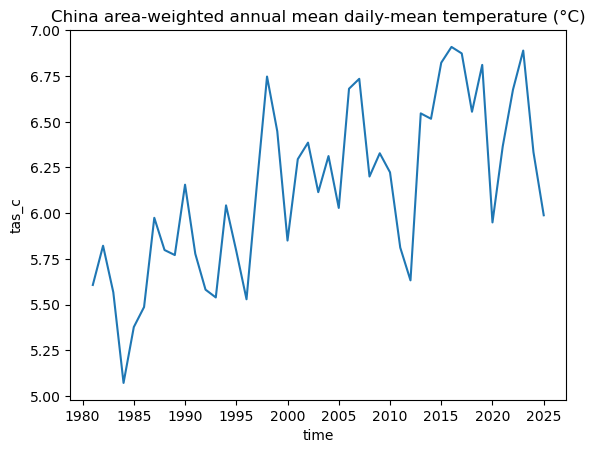

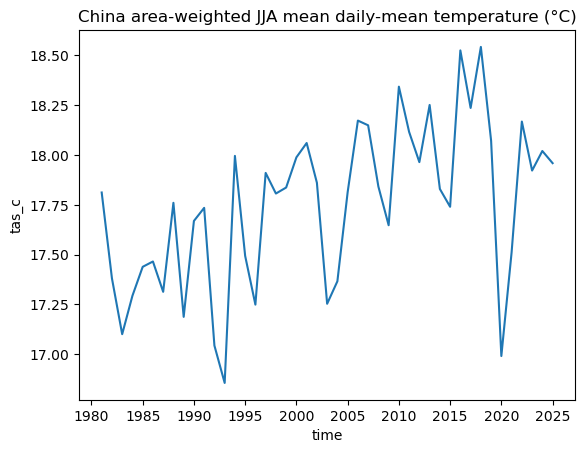

(time
 1981-01-01    5.607398
 1982-01-01    5.821904
 1983-01-01    5.567336
 1984-01-01    5.071528
 1985-01-01    5.377131
 Freq: YS-JAN, Name: tas_c, dtype: float32,
 time
 1981-01-01    17.811899
 1982-01-01    17.381176
 1983-01-01    17.100967
 1984-01-01    17.293505
 1985-01-01    17.438883
 Freq: YS-JAN, Name: tas_c, dtype: float32)

In [14]:
# Cell 8 — Spatial analysis: China-masked area-weighted annual and JJA mean temperature time series
# ----------------------------------------------------------------------------------------------
# Purpose:
#   1) Convert NCEP air temperature from Kelvin to Celsius
#   2) Mask the data to the China polygon (grid cells outside China -> NaN)
#   3) Compute area-weighted annual mean and JJA mean time series for China
#   4) Plot the resulting time series
#
# Scientific notes:
#   - For a regular lat–lon grid, the area of a grid cell is proportional to cos(latitude).
#     Using cos(lat) as weights yields an area-weighted mean over the sphere (up to a constant).
#   - If you are using a Gaussian latitude grid (e.g., files with ".gauss" in the name),
#     use latitude-band weights instead of cos(lat) alone.

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr  # explicit import for clarity in standalone cell

# -------------------------------------------------------------------
# Sanity check: confirm the expected variable exists in the dataset
# -------------------------------------------------------------------
# NCEP temperature variable is typically called "air".
if "air" not in ds.data_vars:
    raise RuntimeError(f"'air' not found in ds2. Available: {list(ds2.data_vars)}")

# -------------------------------------------------------------------
# Convert units: Kelvin -> Celsius
# -------------------------------------------------------------------
# NCEP reanalysis temperatures are stored in Kelvin (K).
# Subtract 273.15 to get degrees Celsius (°C).
tas_c = (ds["air"] - 273.15).rename("tas_c")

# -------------------------------------------------------------------
# Apply China mask
# -------------------------------------------------------------------
# china_mask is a boolean DataArray on the same (lat, lon) grid:
#   True  -> inside China
#   False -> outside China
# .where(mask) sets values outside China to NaN so they do not contribute
# to subsequent means.
tas_china = tas_c.where(china_mask)

# -------------------------------------------------------------------
# Define area weights for a regular latitude-longitude grid
# -------------------------------------------------------------------
# On a spherical Earth, the surface area represented by a latitude band
# is proportional to cos(latitude). For a regular lat–lon grid, each
# longitude cell within the band has equal area, so cos(lat) is sufficient
# (the constant Δlon cancels in normalization).
#
# We build a 1D weight vector over lat, which xarray will broadcast to (lat, lon).
w_lat = xr.DataArray(
    np.cos(np.deg2rad(tas_china["lat"])),   # convert degrees->radians then take cosine
    coords={"lat": tas_china["lat"]},       # label weights by latitude coordinate
    dims=("lat",),                          # weights vary only along latitude
)

def area_weighted_mean(da: xr.DataArray) -> xr.DataArray:
    """
    Compute an area-weighted mean over latitude and longitude for a regular lat–lon grid.

    Parameters
    ----------
    da : xr.DataArray
        DataArray with dimensions including ('lat', 'lon').

    Returns
    -------
    xr.DataArray
        Weighted mean collapsed over ('lat', 'lon'), preserving remaining dimensions (e.g., time).
    """
    # .weighted(w_lat) applies latitude weights; mean collapses over spatial dims.
    # skipna=True ensures masked-out NaNs (outside China) are ignored.
    return da.weighted(w_lat).mean(dim=("lat", "lon"), skipna=True)

# -------------------------------------------------------------------
# Compute annual mean time series
# -------------------------------------------------------------------
# resample(time="YS") groups by calendar year starting on Jan 1 ("Year Start"),
# then mean() computes the annual mean from daily values.
tas_ann_mean = area_weighted_mean(tas_china.resample(time="YS").mean())

# -------------------------------------------------------------------
# Compute JJA mean time series (per year)
# -------------------------------------------------------------------
# Select only summer days (June–July–August) using xarray's season accessor,
# then compute yearly mean over those days.
tas_jja = tas_china.sel(time=tas_china["time"].dt.season == "JJA")
tas_jja_mean = area_weighted_mean(tas_jja.resample(time="YS").mean())

# -------------------------------------------------------------------
# Plot results
# -------------------------------------------------------------------
plt.figure()
tas_ann_mean.plot()
plt.title("China area-weighted annual mean daily-mean temperature (°C)")
plt.show()

plt.figure()
tas_jja_mean.plot()
plt.title("China area-weighted JJA mean daily-mean temperature (°C)")
plt.show()

# -------------------------------------------------------------------
# Return small tabular preview 
# -------------------------------------------------------------------
tas_ann_mean.to_pandas().head(), tas_jja_mean.to_pandas().head()


In [16]:
# Cell 9 — Prepare China-masked temperature in °C (daily)

import xarray as xr

tas_c = (ds["air"] - 273.15).rename("tas_c")  # daily mean temperature in °C
tas_china = tas_c.where(china_mask)            # outside China -> NaN

tas_china


<xarray.DataArray 'tas_c' (time: 16436, lat: 73, lon: 144)> Size: 691MB
dask.array<where, shape=(16436, 73, 144), dtype=float32, chunksize=(365, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * time     (time) datetime64[ns] 131kB 1981-01-01 1981-01-02 ... 2025-12-31
  * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5

In [17]:
# Cell 10 — Compute annual mean temperature maps over China

# Annual means from daily data; "YS" = Year Start frequency
tas_ann = tas_china.resample(time="YS").mean().rename("tas_ann_c")

tas_ann

<xarray.DataArray 'tas_ann_c' (time: 45, lat: 73, lon: 144)> Size: 2MB
dask.array<transpose, shape=(45, 73, 144), dtype=float32, chunksize=(1, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 360B 1981-01-01 1982-01-01 ... 2025-01-01

In [18]:
# Cell 11 — Compute 1981–2000 baseline climatology (annual) and anomalies

BASE_START, BASE_END = "1981-01-01", "2000-12-31"

# Baseline climatology: mean annual temperature (map) over 1981–2000
tas_baseline = tas_ann.sel(time=slice(BASE_START, BASE_END)).mean("time", skipna=True).rename("tas_baseline_c")

# Annual anomalies relative to baseline (same units: °C)
tas_anom = (tas_ann - tas_baseline).rename("tas_anom_c")

tas_baseline, tas_anom

(<xarray.DataArray 'tas_baseline_c' (lat: 73, lon: 144)> Size: 42kB
 dask.array<mean_agg-aggregate, shape=(73, 144), dtype=float32, chunksize=(73, 144), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
   * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5,
 <xarray.DataArray 'tas_anom_c' (time: 45, lat: 73, lon: 144)> Size: 2MB
 dask.array<sub, shape=(45, 73, 144), dtype=float32, chunksize=(1, 73, 144), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
   * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
   * time     (time) datetime64[ns] 360B 1981-01-01 1982-01-01 ... 2025-01-01)

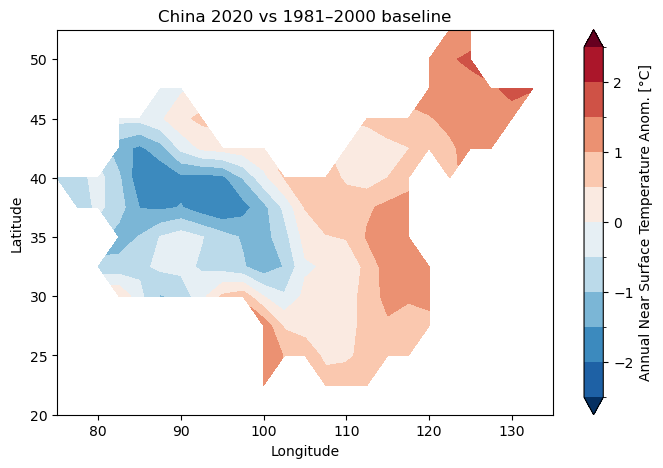

In [28]:
# Cell 12 — Nicer anomaly maps: zoom to China + contourf-style plot

import numpy as np
import matplotlib.pyplot as plt

def plot_china_anomaly(
    da_anom: xr.DataArray,
    *,
    year: int,
    bounds: tuple = (73, 135, 54, 18),  # (lon_min, lon_max, lat_max, lat_min) ~ China bounds
    vlim: float = 5.0,                  # symmetric color range (°C)
    step: float = 0.5,                  # contour interval (°C)
):
    """
    Plot a China-zoomed annual anomaly map using contourf-like levels.
    da_anom should be the annual anomaly DataArray with dims (time, lat, lon).
    """
    lon_min, lon_max, lat_min, lat_max = bounds

    # Select requested year (annual-resampled data typically sits at YYYY-01-01)
    t = f"{year}-01-01"
    m = da_anom.sel(time=t).sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    if m.size == 0:
        raise ValueError(
            f"Empty selection. year={year}, bounds={bounds}\n"
            f"lon range in data: [{float(da_anom.lon.min())}, {float(da_anom.lon.max())}]\n"
            f"lat range in data: [{float(da_anom.lat.min())}, {float(da_anom.lat.max())}]\n"
            f"lat ascending? {bool(da_anom.lat[0] < da_anom.lat[-1])}"
    )
    # Robust symmetric scaling: if max anomaly smaller than vlim, tighten automatically (optional)
    maxabs = float(np.nanmax(np.abs(m.values)))
    v = max(vlim, np.ceil(maxabs * 2) / 2)  # round up to nearest 0.5

    levels = np.arange(-v, v + step, step)

    plt.figure(figsize=(8, 5))
    # xarray.DataArray.plot.contourf uses matplotlib contourf underneath
    cf = m.plot.contourf(
        x="lon", y="lat",
        levels=levels,
        extend="both",
        add_colorbar=True,
        cbar_kwargs={"label": "Annual Near Surface Temperature Anom. [°C]"},
    )
    plt.title(f"China {year} vs 1981–2000 baseline")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Example: plot 2020 anomaly
plot_china_anomaly(tas_anom, year=2020, vlim=2.0, step=0.5)


In [29]:
# Cell 13 — Export anomaly maps to NetCDF

from pathlib import Path

out_nc = OUTPUT_DIR / "china_annual_t2m_anomaly_1981_2000_baseline_1981_2025.nc"

# Package into a Dataset with useful metadata
ds_out = xr.Dataset(
    data_vars={
        "tas_ann_c": tas_ann,
        "tas_baseline_c": tas_baseline,
        "tas_anom_c": tas_anom,
        "china_mask": china_mask.astype("int8"),
    },
    attrs={
        "title": "China annual 2m temperature anomalies relative to 1981–2000 baseline (NCEP Reanalysis daily avgs)",
        "baseline_period": "1981-2000",
        "units": "degC",
        "notes": "tas_ann_c computed from daily mean air temperature; anomalies computed as tas_ann_c - tas_baseline_c. Mask applied using World Bank official boundaries.",
    },
)

# Add variable-level attributes (helps reviewers/users)
ds_out["tas_ann_c"].attrs.update({"long_name": "Annual mean near-surf (sig995)  temperature over China", "units": "degC"})
ds_out["tas_baseline_c"].attrs.update({"long_name": "1981–2000 baseline annual near-surf temperature (sig995) over China", "units": "degC"})
ds_out["tas_anom_c"].attrs.update({"long_name": "Annual near-surf temperature (sig995) temperature anomaly over China relative to 1981–2000", "units": "degC"})
ds_out["china_mask"].attrs.update({"long_name": "China land mask (1 inside China, 0 outside)", "units": "1"})

# Write to disk
ds_out.to_netcdf(out_nc)

out_nc

PosixPath('outputs/china_annual_t2m_anomaly_1981_2000_baseline_1981_2025.nc')

In [33]:
# Cell — Prepare daily 2m temperature over China (°C)

import xarray as xr
import numpy as np

# Daily mean temperature in °C
tas = (ds["air"] - 273.15).rename("tas")

# Mask outside China
tas_china = tas.where(china_mask)

tas_china


<xarray.DataArray 'tas' (time: 16436, lat: 73, lon: 144)> Size: 691MB
dask.array<where, shape=(16436, 73, 144), dtype=float32, chunksize=(365, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * time     (time) datetime64[ns] 131kB 1981-01-01 1981-01-02 ... 2025-12-31
  * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5

In [37]:
# Cell — Build exceedance boolean: tas > daily p90(threshold)

# Align each daily value with its day-of-year threshold
# Result: (time, lat, lon) boolean
exceed = (tas_china.groupby("time.dayofyear") > t90).rename("exceed")

exceed


<xarray.DataArray 'exceed' (time: 16436, lat: 73, lon: 144)> Size: 173MB
dask.array<gt, shape=(16436, 73, 144), dtype=bool, chunksize=(365, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 131kB 1981-01-01 1981-01-02 ... 2025-12-31
  * lon        (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
    quantile   (time) float64 131kB 0.9 0.9 0.9 0.9 0.9 ... 0.9 0.9 0.9 0.9 0.9
    dayofyear  (time) int64 131kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365

In [38]:
# Cell — WSDI core: count days in spells of >=5 consecutive exceedances, per year (vectorized)

def wsdi_from_exceedance(exceed_year: xr.DataArray, min_run: int = 5) -> xr.DataArray:
    """
    Compute WSDI for a single year:
      count of days that belong to runs of True of length >= min_run
    Parameters
    ----------
    exceed_year : xr.DataArray
        Boolean DataArray with dims (time, lat, lon) for one year only.
    min_run : int
        Minimum consecutive-day run length to qualify as a warm spell.
    Returns
    -------
    xr.DataArray
        Integer DataArray (lat, lon): annual WSDI in days.
    """
    # Convert True/False to 1/0 to make run-length logic easier
    x = exceed_year.fillna(False).astype(np.int8)

    # We'll compute run lengths using a forward/backward scan implemented with numpy.
    # For performance, operate on a (time, npoints) view and reshape back.
    t, ny, nx = x.shape
    arr = x.data  # may be dask or numpy; convert safely below

    # Ensure we have a numpy array for the run-length calculation for this year block.
    arr = np.array(arr)  # year blocks are small enough (~365xgrid)

    # Flatten spatial dims: (time, npts)
    arr2 = arr.reshape(t, ny * nx)

    # Forward run lengths: f[i] = length of current run ending at i (if exceed), else 0
    f = np.zeros_like(arr2, dtype=np.int16)
    f[0] = arr2[0]
    for i in range(1, t):
        f[i] = (f[i - 1] + 1) * arr2[i]

    # Backward run lengths: b[i] = length of current run starting at i (if exceed), else 0
    b = np.zeros_like(arr2, dtype=np.int16)
    b[-1] = arr2[-1]
    for i in range(t - 2, -1, -1):
        b[i] = (b[i + 1] + 1) * arr2[i]

    # Total run length for each day in a run:
    # run_len[i] = f[i] + b[i] - 1 (only meaningful where arr2[i]==1)
    run_len = (f + b - 1) * arr2

    # Spell membership: days where run length >= min_run
    in_spell = run_len >= min_run

    # WSDI: count spell days over time dimension -> (npts,)
    wsdi = in_spell.sum(axis=0).astype(np.int32)

    # Reshape back to (lat, lon) and return as DataArray
    wsdi_da = xr.DataArray(
        wsdi.reshape(ny, nx),
        coords={"lat": exceed_year["lat"], "lon": exceed_year["lon"]},
        dims=("lat", "lon"),
        name="wsdi",
    )
    wsdi_da.attrs.update({
        "long_name": f"Warm Spell Duration Index (days) with runs >= {min_run} days",
        "definition": "Annual count of days in spells of >=5 consecutive days with daily mean temperature > 90th percentile of 1981–2000 baseline (calendar-day percentile).",
        "units": "days",
    })
    return wsdi_da


# Compute WSDI for each year 1981–2025
years = np.arange(1981, 2026)

wsdi_maps = []
for y in years:
    ex_y = exceed.sel(time=str(y))
    wsdi_y = wsdi_from_exceedance(ex_y, min_run=5).expand_dims(time=[np.datetime64(f"{y}-01-01")])
    wsdi_maps.append(wsdi_y)

wsdi = xr.concat(wsdi_maps, dim="time").rename("wsdi")
wsdi


<xarray.DataArray 'wsdi' (time: 45, lat: 73, lon: 144)> Size: 2MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(45, 73, 144), dtype=int32)
Coordinates:
  * time     (time) datetime64[s] 360B 1981-01-01 1982-01-01 ... 2025-01-01
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
Attributes:
    long_name:   Warm Spell Duration Index (days) with runs >= 5 days
    definition:  Annual count of days in spells of >=5 consecutive days with ...
    units:       days

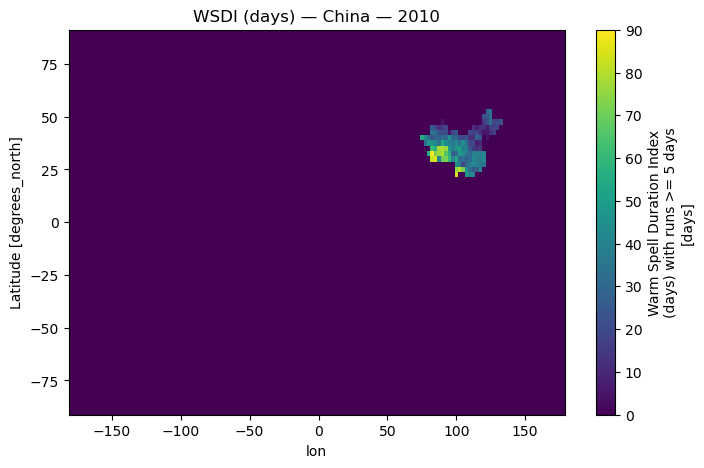

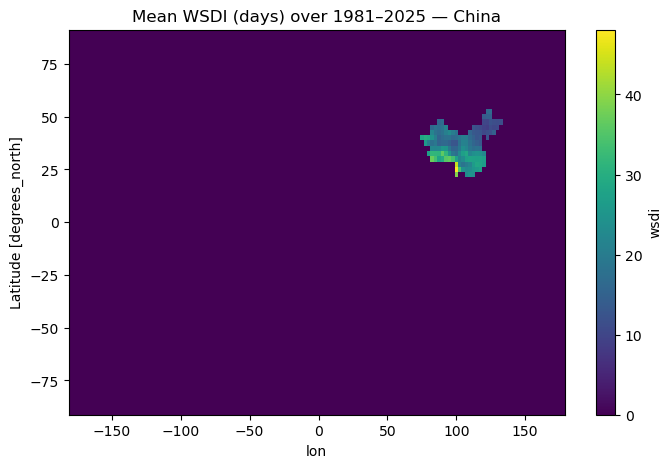

In [39]:
# Cell — Quick sanity check plots

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
wsdi.sel(time="2010-01-01").plot()
plt.title("WSDI (days) — China — 2010")
plt.show()

plt.figure(figsize=(8,5))
wsdi.mean("time").plot()
plt.title("Mean WSDI (days) over 1981–2025 — China")
plt.show()


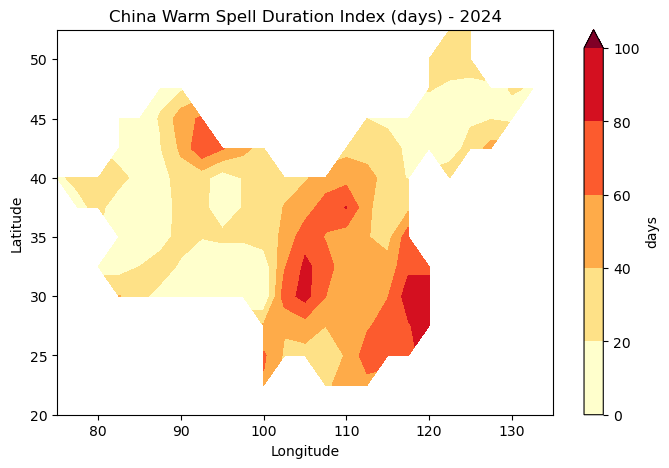

In [53]:
# Cell — WSDI plot with NaNs transparent

import matplotlib.pyplot as plt
import numpy as np

def plot_wsdi_map(wsdi_da, year, bounds=(73,135,18,54), vmax=100, step=5):
    lon_min, lon_max, lat_min, lat_max = bounds

    m = wsdi_da.sel(time=f"{year}-01-01")
    m = m.sel(lon=slice(lon_min, lon_max))
    # safe lat slicing for descending/ascending
    if float(m.lat.values[0]) < float(m.lat.values[-1]):
        m = m.sel(lat=slice(lat_min, lat_max))
    else:
        m = m.sel(lat=slice(lat_max, lat_min))
    
    levels = np.arange(0, vmax + step, step)

    plt.figure(figsize=(8,5))
    ax = plt.gca()
    ax.set_facecolor("white")  # makes masked-out areas look clean

    # Ensure outside-China is NaN (in case wsdi_da wasn't masked yet)
    m = m.where(china_mask)

    m.plot.contourf(
        x="lon", y="lat",
        levels=levels,
        cmap="YlOrRd",
        extend="max",
        cbar_kwargs={"label": "days"},
    )

    plt.title(f"China Warm Spell Duration Index (days) - {year}")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.show()

plot_wsdi_map(wsdi, 2024, vmax = 100, step=20)


In [40]:
# Cell — Save WSDI maps to NetCDF

out_wsdi = OUTPUT_DIR / "china_wsdi_annual_1981_2025_ncep_daily_p90_baseline_1981_2000.nc"

ds_wsdi = xr.Dataset(
    data_vars={
        "wsdi": wsdi,
        "tas_p90": t90,                 # keep thresholds used (dayofyear, lat, lon)
        "china_mask": china_mask.astype("int8"),
    },
    attrs={
        "title": "China annual Warm Spell Duration Index (WSDI) from NCEP daily mean temperature",
        "wsdi_definition": "Annual count of days in spells of >=5 consecutive days where daily mean temperature > 90th percentile of 1981–2000 baseline (calendar-day percentile).",
        "baseline_period": "1981-2000",
        "min_spell_length_days": 5,
        "temperature_units": "degC",
        "notes": "WSDI computed explicitly using run-length logic on daily exceedance boolean; thresholds are day-of-year specific and interpolated for missing values (e.g. Feb 29).",
    },
)

ds_wsdi["wsdi"].attrs.update({"units": "days"})
ds_wsdi["tas_p90"].attrs.update({"units": "degC", "long_name": "Daily (day-of-year) 90th percentile threshold from 1981–2000 baseline"})
ds_wsdi["china_mask"].attrs.update({"units": "1", "long_name": "China mask (1 inside China, 0 outside)"})

ds_wsdi.to_netcdf(out_wsdi)

out_wsdi


PosixPath('outputs/china_wsdi_annual_1981_2025_ncep_daily_p90_baseline_1981_2000.nc')